In [1]:
import cv2
image = cv2.imread("floorplans/L2.jpg")
print(image)
window_name = 'image'

# Using cv2.imshow() method
# Displaying the image
cv2.imshow(window_name, image)

# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0)

# closing all open windows
cv2.destroyAllWindows()


[[[161 176 185]
  [161 176 185]
  [161 176 185]
  ...
  [208 217 221]
  [207 216 220]
  [206 215 219]]

 [[161 176 185]
  [161 176 185]
  [161 176 185]
  ...
  [209 218 222]
  [207 216 220]
  [207 216 220]]

 [[161 176 185]
  [161 176 185]
  [161 176 185]
  ...
  [209 218 222]
  [208 217 221]
  [207 216 220]]

 ...

 [[161 169 169]
  [161 169 169]
  [162 170 170]
  ...
  [208 206 205]
  [208 206 205]
  [217 215 214]]

 [[160 168 168]
  [161 169 169]
  [163 171 171]
  ...
  [207 205 204]
  [210 208 207]
  [221 219 218]]

 [[160 168 168]
  [161 169 169]
  [163 171 171]
  ...
  [207 205 204]
  [212 210 209]
  [226 224 223]]]


[[[190 201 209]
  [190 201 209]
  [190 201 209]
  ...
  [217 225 232]
  [216 224 231]
  [215 223 230]]

 [[190 201 209]
  [190 201 209]
  [190 201 209]
  ...
  [217 225 232]
  [216 224 231]
  [215 223 230]]

 [[190 201 209]
  [190 201 209]
  [190 201 209]
  ...
  [217 225 232]
  [216 224 231]
  [216 224 231]]

 ...

 [[170 182 188]
  [170 182 188]
  [170 182 188]
  ...
  [225 220 219]
  [224 219 218]
  [227 222 221]]

 [[170 182 188]
  [170 182 188]
  [170 182 188]
  ...
  [227 222 221]
  [226 221 220]
  [229 224 223]]

 [[170 182 188]
  [170 182 188]
  [170 182 188]
  ...
  [228 223 222]
  [227 222 221]
  [230 225 224]]]


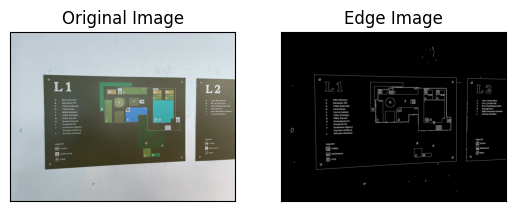

[[[161 176 185]
  [161 176 185]
  [161 176 185]
  ...
  [208 217 221]
  [207 216 220]
  [206 215 219]]

 [[161 176 185]
  [161 176 185]
  [161 176 185]
  ...
  [209 218 222]
  [207 216 220]
  [207 216 220]]

 [[161 176 185]
  [161 176 185]
  [161 176 185]
  ...
  [209 218 222]
  [208 217 221]
  [207 216 220]]

 ...

 [[161 169 169]
  [161 169 169]
  [162 170 170]
  ...
  [208 206 205]
  [208 206 205]
  [217 215 214]]

 [[160 168 168]
  [161 169 169]
  [163 171 171]
  ...
  [207 205 204]
  [210 208 207]
  [221 219 218]]

 [[160 168 168]
  [161 169 169]
  [163 171 171]
  ...
  [207 205 204]
  [212 210 209]
  [226 224 223]]]


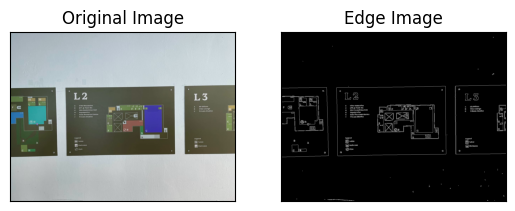

[[[176 191 200]
  [175 190 199]
  [174 189 198]
  ...
  [222 230 230]
  [221 229 229]
  [222 230 230]]

 [[175 190 199]
  [175 190 199]
  [175 190 199]
  ...
  [221 229 229]
  [221 229 229]
  [222 230 230]]

 [[173 188 197]
  [174 189 198]
  [175 190 199]
  ...
  [221 229 229]
  [221 229 229]
  [222 230 230]]

 ...

 [[165 171 176]
  [165 171 176]
  [164 170 175]
  ...
  [230 225 224]
  [234 229 228]
  [242 237 236]]

 [[165 171 176]
  [165 171 176]
  [165 171 176]
  ...
  [233 228 227]
  [235 230 229]
  [241 236 235]]

 [[165 171 176]
  [165 171 176]
  [165 171 176]
  ...
  [237 232 231]
  [236 231 230]
  [240 235 234]]]


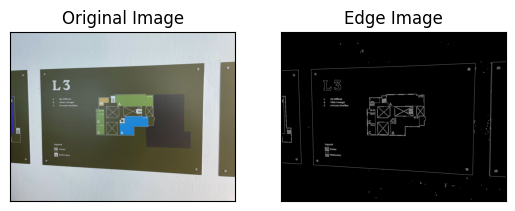

[[[158 177 185]
  [158 177 185]
  [159 178 186]
  ...
  [201 210 214]
  [201 210 214]
  [200 209 213]]

 [[159 178 186]
  [159 178 186]
  [160 179 187]
  ...
  [202 211 215]
  [201 210 214]
  [201 210 214]]

 [[161 180 188]
  [161 180 188]
  [160 179 187]
  ...
  [203 212 216]
  [202 211 215]
  [202 211 215]]

 ...

 [[164 175 183]
  [166 177 185]
  [168 179 187]
  ...
  [170 162 162]
  [166 161 160]
  [165 160 159]]

 [[164 175 183]
  [166 177 185]
  [168 179 187]
  ...
  [170 162 162]
  [166 161 160]
  [165 160 159]]

 [[164 175 183]
  [167 178 186]
  [169 180 188]
  ...
  [170 162 162]
  [166 161 160]
  [165 160 159]]]


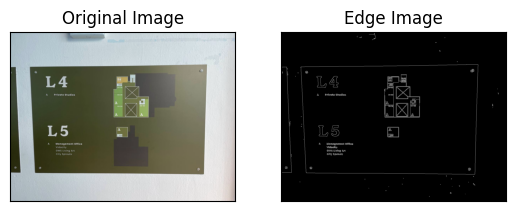

In [ ]:
import cv2
from matplotlib import pyplot as plt

def displayCann(source):
    image = cv2.imread(source)
    print(image)
    window_name = 'image'

    # Using cv2.imshow() method
    # Displaying the image
    # waits for user to press any key
    # (this is necessary to avoid Python kernel form crashing)

    edges = cv2.Canny(image,100,200)
    
    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
 
    plt.show()

import os
for path in os.listdir("floorplans"):
    displayCann("floorplans/" + path)


In [3]:
# import the necessary packages
import numpy as np
import cv2
import argparse

def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect

def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


coords = [(190, 245), (995, 260), (200, 780), (990, 740)]
image = cv2.imread("floorplans/L1.jpg")
for (x, y) in coords:
    # Draw a small circle (radius=5) in red
    cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
pts = np.array(coords, dtype = "float32")
# apply the four point tranform to obtain a "birds eye view" of
# the image
warped = four_point_transform(image, pts)
# show the original and warped images
cv2.imshow("Original", image)
cv2.imshow("Warped", warped)
cv2.waitKey(0)

-1

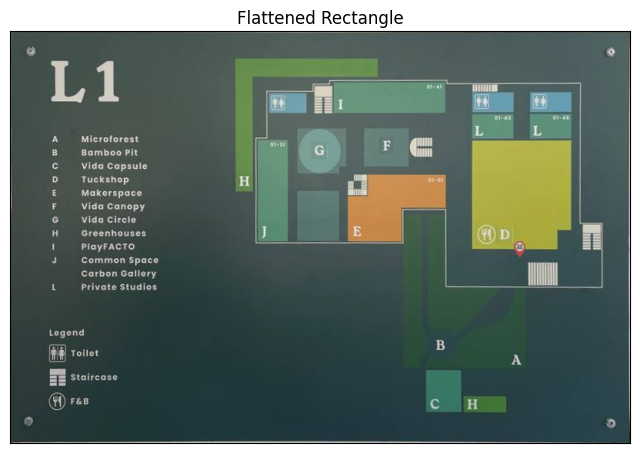

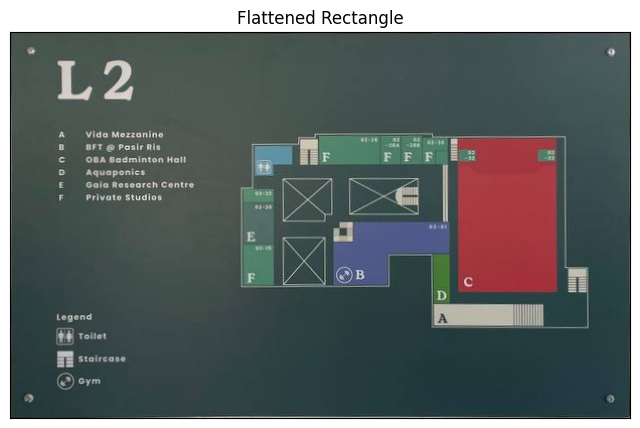

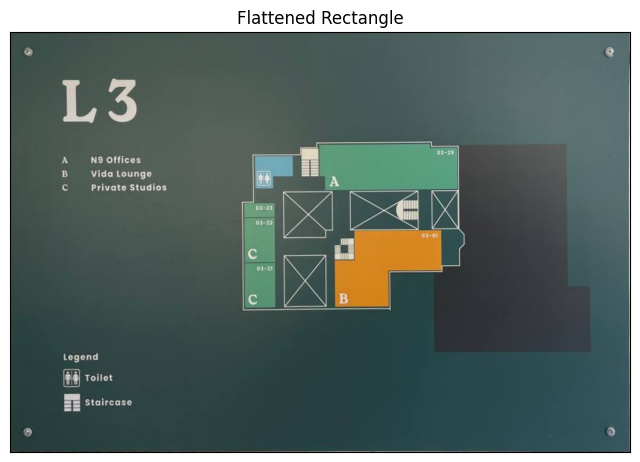

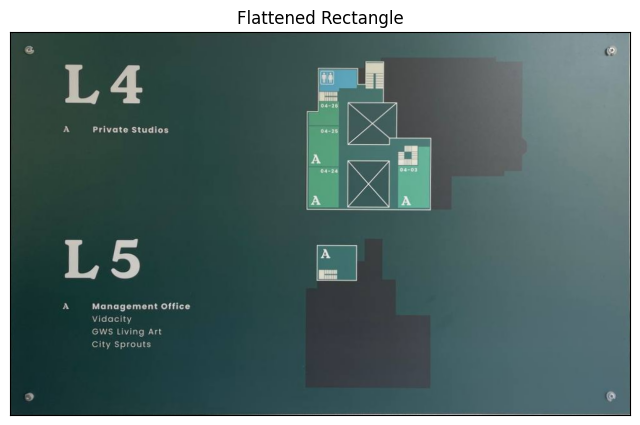

In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

def order_points(pts):
    # Order the points in the following order: top-left, top-right, bottom-right, bottom-left.
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    
    return rect

def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


def draw_dots_on_largest_rectangle(source):
    """
    Finds the largest rectangle in 'image' and draws red dots on its corners.
    Modifies the image in-place and returns it.
    """
    image = cv2.imread(source)
    if image is None:
        return None
    
    rect = find_largest_quadrilateral(image)
    if rect is not None:
        # rect has shape (4,1,2)
        corners = rect.reshape((4, 2))  # Now it's (4,2)
        corners = order_points(corners)
        # Then draw your circles
        for (x, y) in corners:
            cv2.circle(image, (int(x), int(y)), 5, (0, 0, 255), -1)
    return image

def find_largest_quadrilateral(image):
    """
    Finds the largest 4-sided contour (quadrilateral) in the image.
    Returns the approximated contour (4 points) if found, otherwise returns None.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Edge detection with Canny
    edged = cv2.Canny(blurred, 50, 200)
    
    # Use a morphological closing to help join broken edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    
    # Find contours in the edged image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_area = 0
    best_approx = None
    # Loop over the contours
    for cnt in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        
        # Check if it has 4 points
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > largest_area:
                largest_area = area
                best_approx = approx
                
    return best_approx


def process_image(source):
    image = cv2.imread(source)
    if image is None:
        print("Could not open image:", source)
        return None
    else:
        rect = find_largest_quadrilateral(image)
        if rect is not None:
            # rect has shape (4,1,2)
            corners = rect.reshape((4, 2))  # Now it's (4,2)
            corners = order_points(corners)
            transformed_image = four_point_transform(image, corners)
            return transformed_image
    

def batch_process(path, show=False):
    warped_images = []
    dotted_images = []
    for image in os.listdir(path):
        source = os.path.join(path, image)
        dotted_image = draw_dots_on_largest_rectangle(source)
        warped_image = process_image(source)

        warped_images.append(warped_image)
        dotted_images.append(dotted_image)

    if show:
        for image in warped_images:
            if image is not None:
                # plt.subplot(222)
                plt.figure(figsize=(8, 6))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title('Flattened Rectangle')
                plt.xticks([]), plt.yticks([])
                plt.show()
        # for image in dotted_images:
        #     if image is not None:
        #         plt.subplot(122)
        #         plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #         plt.title('Flattened Rectangle')
        #         plt.xticks([]), plt.yticks([])
        #         plt.show()
    return warped_images



focused_images = batch_process("floorplans", show=True)

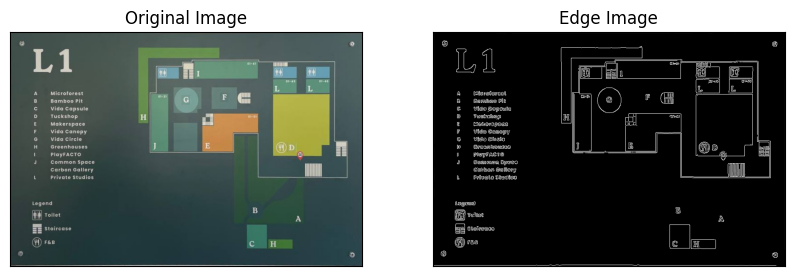

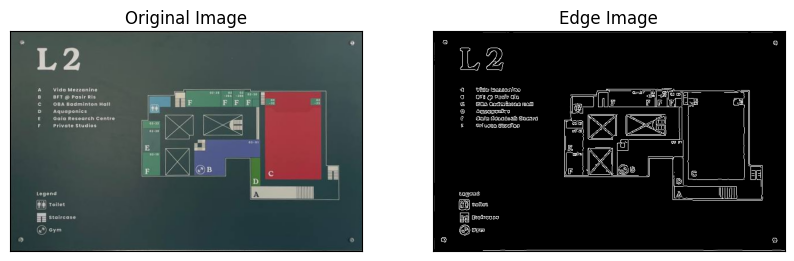

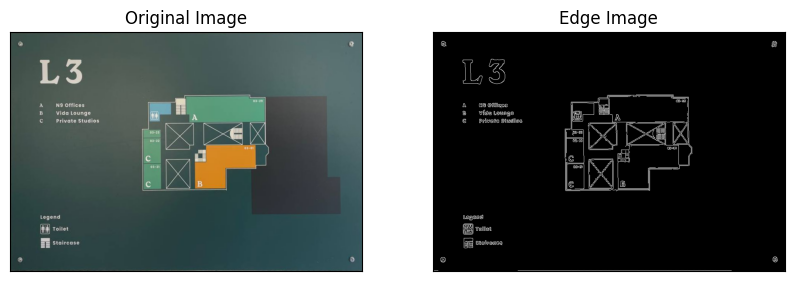

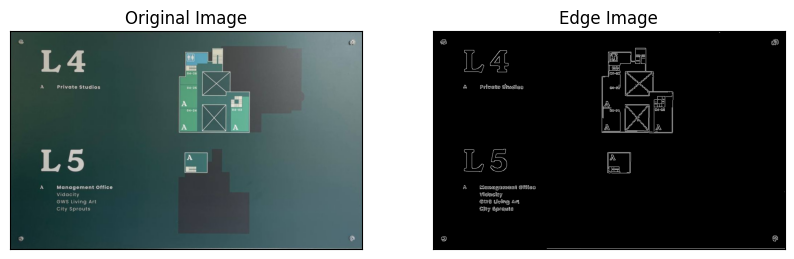

In [22]:
import cv2
from matplotlib import pyplot as plt

def displayTransformation(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Edge detection with Canny
    edges = cv2.Canny(image, 50, 200)
        
    # Create a figure to show both images
    plt.figure(figsize=(10, 5))  # Sets the figure size
    plt.subplot(121)  # Position 1 in a grid with 1 row and 2 columns
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Display the original image
    plt.title('Original Image')
    plt.xticks([]), plt.yticks([])  # Remove axis marks
    
    plt.subplot(122)  # Position 2 in the same grid
    plt.imshow(edges, cmap='gray')  # Display the edge image
    plt.title('Edge Image')
    plt.xticks([]), plt.yticks([])

    plt.show()  # Display the plots

for image in focused_images:
    # print(image)
    displayTransformation(image)

In [35]:
def segment_and_edge_detect(image):
    # 1. Convert image to HSV and create a mask for the target color
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 50, 50])   
    upper_green = np.array([80, 255, 255]) 
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Optional morphological operations to clean the mask
    kernel = np.ones((5, 5), np.uint8)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel)

    # 2. Extract only the green region from the original image
    segmented_region = cv2.bitwise_and(image, image, mask=green_mask)

    # 3. Detect edges with Canny on the segmented region
    gray_segmented = cv2.cvtColor(segmented_region, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_segmented, 50, 150)

    # 4. Find contours from the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours if desired
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Adjust threshold as needed
            filtered_contours.append(contour)

    # Draw the detailed contour outlines on the original image
    cv2.drawContours(image, filtered_contours, -1, (0, 255, 0), 2)

    # Show the results
    cv2.imshow('Original with Detailed Contours', image)
    cv2.imshow('Green Mask', green_mask)
    cv2.imshow('Segmented Region', segmented_region)
    cv2.imshow('Edges in Segmented Region', edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# for image in focused_images:
#     # print(image)
segment_and_edge_detect(focused_images[0])

In [37]:
import cv2
import pytesseract
from pytesseract import Output

def label_image_with_ocr(image):
    # Read the image using OpenCV
    
    # Optional: Convert to RGB if needed
    # Tesseract can handle BGR, but some people prefer to ensure it's RGB:
    # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform OCR using PyTesseract
    # 'image_to_data' returns detailed information including bounding boxes
    ocr_data = pytesseract.image_to_data(image, output_type=Output.DICT)

    # Loop over each piece of detected text
    for i in range(len(ocr_data["text"])):
        text = ocr_data["text"][i]
        conf = int(ocr_data["conf"][i])
        
        # Filter out low-confidence text (adjust threshold as needed)
        if conf > 60 and text.strip():
            x = ocr_data["left"][i]
            y = ocr_data["top"][i]
            w = ocr_data["width"][i]
            h = ocr_data["height"][i]

            # Draw a bounding box around the detected text
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Put recognized text above the bounding box
            cv2.putText(image, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the result
    cv2.imshow("OCR Result", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

label_image_with_ocr(focused_images[0])

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.